In [108]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, ConvLSTM1D, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, SpatialDropout1D, Dropout, TimeDistributed

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import f1_score
import sklearn

import pickle

from featurize import featurize

from scaler import CustomScaler
from VAE import get_auth_model

def get_eer(scores_legit, scores_adv):
	scores_legit = sorted(scores_legit)
	scores_adv = sorted(scores_adv)
	
	#treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
	for c, threshold in enumerate(scores_legit):
		frr = c * 1.0 / len(scores_legit)
		adv_index = next((x[0] for x in enumerate(scores_adv) if x[1] > threshold), len(scores_adv))
		far = 1 - (adv_index * 1.0 / len(scores_adv))
		if frr >= far:
			return threshold, far
	print("Failure")

class SplitLayer(tf.keras.layers.Layer):
    def __init__(self, layers):
        super(SplitLayer, self).__init__()
        self.layers = layers

    def call(self, inputs):
        return tf.gather(inputs,indices=self.layers,axis=-1)


def get_new_auth_model(input_dim=(200,16)):
    #input_dim = (200,16)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    xs = []
    
    for i in range(input_dim[1]):
        
        x = SplitLayer(i)(inputs)
        reshaped = Reshape((200, 1))(x)
        
        x = Conv1D(100, 3, strides=2, padding="same")(reshaped)   #, kernel_regularizer=l2(1e-5)
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
        
        x = Conv1D(100, 3, strides=1,  padding="same")(x)     #   kernel_regularizer=l2(1e-5),
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
        
        x = Conv1D(100, 3, strides=1,  padding="same")(x)     #   kernel_regularizer=l2(1e-5),
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)

        
        xs.append(x)
    
    x = layers.Concatenate()(xs)
    x = LSTM(10)(x)

    x = Dense(25, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(10, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    #x = layers.Lambda(lambda x: x / 2)
    out = x

    model = keras.Model(inputs, out, name="LSTM_classifier_v2")
    
    return model
"""
def get_new_auth_model2(input_dim=(200,16)):
    #input_dim = (200,16)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    
    layer_list = [Conv1D(100, 3, strides=1, padding="same"),
        MaxPooling1D(pool_size=2, strides=None, padding="same"),
        
        Conv1D(100, 3, strides=1,  padding="same"),
        MaxPooling1D(pool_size=2, strides=None, padding="same"),

        Conv1D(100, 3, strides=1, padding="same"),
        MaxPooling1D(pool_size=2, strides=None, padding="same"),
        
        Conv1D(100, 3, strides=1, padding="same"),
        MaxPooling1D(pool_size=2, strides=None, padding="same"),
        
        Conv1D(100, 3, strides=1, padding="same"),
        MaxPooling1D(pool_size=2, strides=None, padding="same"),
        
        Conv1D(100, 7, strides=1, padding="valid"),
        MaxPooling1D(pool_size=2, strides=None, padding="same"),
        
        Flatten(),
        Dense(25, activation="relu")]
    
    xs = []
    
    for i in range(input_dim[1]):
        
        x = SplitLayer(i)(inputs)
        x = Reshape((200, 1))(x)
        
        for layer in layer_list:
            x = layer(x)
        xs.append(x)
    
    x = layers.Concatenate()(xs)

    x = Dense(25, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(10, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation="softmax")(x)
    #x = layers.Lambda(lambda x: x / 2)
    out = x

    model = keras.Model(inputs, out, name="LSTM_classifier_v2")
    
    return model
"""
get_new_auth_model().summary()

Model: "LSTM_classifier_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 200, 16)]    0           []                               
                                                                                                  
 split_layer_234 (SplitLayer)   (None, 200)          0           ['input_25[0][0]']               
                                                                                                  
 split_layer_235 (SplitLayer)   (None, 200)          0           ['input_25[0][0]']               
                                                                                                  
 split_layer_236 (SplitLayer)   (None, 200)          0           ['input_25[0][0]']               
                                                                                 

In [109]:
file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]] # pre-filtered data is "windowed_filtered"
feature_x_data = np.load(f"data/processed/x_{file_name}_features.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy")
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy")
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy")

In [114]:
auth_user = 8

_map = (train_gesture_map == 1)
_test_map = (test_gesture_map == 1)
data_train = x_data[_map] #[train_gesture_map == 1]
labels_train = (y_user.argmax(axis=1) == auth_user)[_map].astype(int) #


shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=0)

scaler = CustomScaler()
scaler.CHANNELS = 6
shuffled_data_train = scaler.fit_and_transform(shuffled_data_train)

np.unique(shuffled_labels_train, return_counts=True)

(array([0, 1]), array([2311,   88]))

Model: "LSTM_classifier_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 200, 6)]     0           []                               
                                                                                                  
 split_layer_256 (SplitLayer)   (None, 200)          0           ['input_27[0][0]']               
                                                                                                  
 split_layer_257 (SplitLayer)   (None, 200)          0           ['input_27[0][0]']               
                                                                                                  
 split_layer_258 (SplitLayer)   (None, 200)          0           ['input_27[0][0]']               
                                                                                 

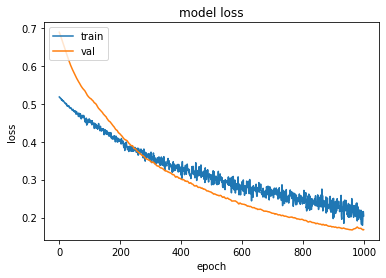

<Figure size 432x288 with 0 Axes>

In [115]:
model = get_new_auth_model((200,6)) # new_
model.summary()

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))



kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=50,
                                                           patience=50, restore_best_weights=True)



history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=1000,
                    batch_size=128, verbose=1,
                    validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                   class_weight={0:0.5, 1:7.5},
                   callbacks=[early_stopping_callback])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.clf()

In [116]:
print(model.predict(shuffled_data_train[val_map]))


15/15 [==============================] - 1s 6ms/step
[[0.09207973]
 [0.5232819 ]
 [0.08365646]
 [0.08683106]
 [0.12108651]
 [0.07708427]
 [0.07476983]
 [0.7291325 ]
 [0.0855781 ]
 [0.08702652]
 [0.07304312]
 [0.08535288]
 [0.08667742]
 [0.11896305]
 [0.08573274]
 [0.15506221]
 [0.08270247]
 [0.09155235]
 [0.07711575]
 [0.07357205]
 [0.09524757]
 [0.07166538]
 [0.07558786]
 [0.08878329]
 [0.08314909]
 [0.08850615]
 [0.08921529]
 [0.07728183]
 [0.07922476]
 [0.07512298]
 [0.07940032]
 [0.08559871]
 [0.08524824]
 [0.1133465 ]
 [0.1357782 ]
 [0.08941016]
 [0.15860921]
 [0.1396105 ]
 [0.0761445 ]
 [0.07421026]
 [0.10257125]
 [0.07929078]
 [0.4610611 ]
 [0.07235672]
 [0.07514978]
 [0.08391813]
 [0.07514004]
 [0.09033588]
 [0.07987241]
 [0.11202065]
 [0.23636572]
 [0.07345033]
 [0.12501204]
 [0.08178551]
 [0.08477883]
 [0.08429185]
 [0.08418581]
 [0.07809337]
 [0.07477432]
 [0.3509178 ]
 [0.39172423]
 [0.30344263]
 [0.11504294]
 [0.08689372]
 [0.08249546]
 [0.07520381]
 [0.08604702]
 [0.08681

34/34 [==============================] - 1s 5ms/step


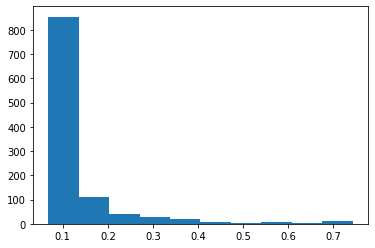

0.8007590132827325
0.9331029502785229
0.8715094339622642


0.9778801843317972

In [117]:
labels_scores = model.predict(scaler.transform(x_data[_test_map])).squeeze()

#labels_scores = model.predict(shuffled_data_train[~val_map]).squeeze()
labels_pred = (labels_scores >= 0.5).astype(int)

labels_true = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)
#labels_true = (shuffled_labels_train[~val_map]).astype(int)


plt.hist(labels_scores, bins=100)
plt.show()

fmeasure = f1_score(labels_true, labels_pred, average = "macro", labels = np.unique(labels_pred)) 
auroc = sklearn.metrics.roc_auc_score(labels_true, labels_scores, labels = np.unique(labels_pred))

print(fmeasure)
print(auroc)
print(sklearn.metrics.precision_score(labels_true, labels_pred, average = "macro", labels = np.unique(labels_pred)) )

sum(labels_true == labels_pred) / len(labels_true)

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

data_train = feature_x_data[_map] #[train_gesture_map == 1]
labels_train = (y_user.argmax(axis=1) == auth_user)[_map].astype(int)

shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=0)

scaler = StandardScaler()
shuffled_data_train = scaler.fit_transform(shuffled_data_train)


kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]

wa_model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced").fit(shuffled_data_train, shuffled_labels_train)





0.587249373433584
0.9554492469568805
0.5535769548174128


0.9686635944700461

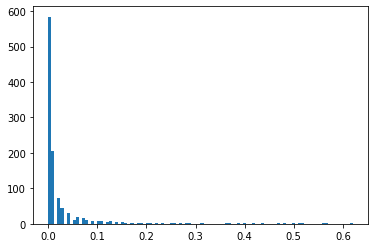

In [121]:

_test_map = (test_gesture_map == 1)

labels_pred = wa_model.predict(scaler.transform(feature_x_data[_test_map]))
labels_scores = wa_model.predict_proba(scaler.transform(feature_x_data[_test_map]))[:, 1]

labels_true = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)

np.histogram(labels_scores)
plt.hist(labels_scores, bins=100)

fmeasure = f1_score(labels_true, labels_pred, average = "macro", labels = np.unique(labels_pred)) 
auroc = sklearn.metrics.roc_auc_score(labels_true, labels_scores, labels = np.unique(labels_pred))

print(fmeasure)
print(auroc)
print(sklearn.metrics.recall_score(labels_true, labels_pred, average = "macro", labels = np.unique(labels_pred)) )

sum(labels_true == labels_pred) / len(labels_true)

In [120]:
np.unique(labels_pred, return_counts=True)

(array([0, 1]), array([1080,    5]))

In [1]:
!pip install tensorflow_ranking

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 60.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
   